In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.8 MB/s eta 0:00:00


In [2]:
from transformers import BertTokenizer, BertModel
import torch

In [3]:
!pip install datasets

from datasets import load_dataset
dataset = load_dataset("stsb_multi_mt", name="en", split="train")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.8 MB/s eta 0:00:00


Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


In [4]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=2043b2da67fba618735349c0cfb96db492d832dc47f1fe8e4a4bc3948e062e1a
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


# Downloading BERT

In [5]:
from sentence_transformers import SentenceTransformer, models

word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
sts_bert_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
!pip install transformers

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

sentence_1 = [i['sentence1'] for i in dataset]
sentence_2 = [i['sentence2'] for i in dataset]
text_cat = [[str(x), str(y)] for x,y in zip(sentence_1, sentence_2)][0]

input_data = tokenizer(text_cat, padding='max_length', max_length = 128, truncation=True, return_tensors="pt")
output = sts_bert_model(input_data)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
similarity = [i['similarity_score'] for i in dataset]
normalized_similarity = [i/5.0 for i in similarity]

# Defining model Architecture for Fine tuning BERT

In [8]:
import torch

class STSBertModel(torch.nn.Module):

    def __init__(self):

        super(STSBertModel, self).__init__()

        word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=128)
        pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
        self.sts_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    def forward(self, input_data):

        output = self.sts_model(input_data)

        return output

In [9]:
class DataSequence(torch.utils.data.Dataset):

    def __init__(self, dataset):

        similarity = [i['similarity_score'] for i in dataset]
        self.label = [i/5.0 for i in similarity]
        self.sentence_1 = [i['sentence1'] for i in dataset]
        self.sentence_2 = [i['sentence2'] for i in dataset]
        self.text_cat = [[str(x), str(y)] for x,y in zip(self.sentence_1, self.sentence_2)]

    def __len__(self):

        return len(self.text_cat)

    def get_batch_labels(self, idx):

        return torch.tensor(self.label[idx])

    def get_batch_texts(self, idx):

        return tokenizer(self.text_cat[idx], padding='max_length', max_length = 128, truncation=True, return_tensors="pt")

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


def collate_fn(texts):

  num_texts = len(texts['input_ids'])
  features = list()
  for i in range(num_texts):
      features.append({'input_ids':texts['input_ids'][i], 'attention_mask':texts['attention_mask'][i]})
  
  return features

In [10]:
class CosineSimilarityLoss(torch.nn.Module):

    def __init__(self,  loss_fct = torch.nn.MSELoss(), cos_score_transformation=torch.nn.Identity()):
      
        super(CosineSimilarityLoss, self).__init__()
        self.loss_fct = loss_fct
        self.cos_score_transformation = cos_score_transformation
        self.cos = torch.nn.CosineSimilarity(dim=1)


    def forward(self, input, label):

        embedding_1 = torch.stack([inp[0] for inp in input])
        embedding_2 = torch.stack([inp[1] for inp in input])

        output = self.cos_score_transformation(self.cos(embedding_1, embedding_2))

        return self.loss_fct(output, label.squeeze())

# Fine Tuning BERT

In [11]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model = STSBertModel()

    criterion = CosineSimilarityLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_dataset = DataSequence(dataset)
    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=bs, shuffle=True)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    best_acc = 0.0
    best_loss = 1000

    for i in range(epochs):

        total_acc_train = 0
        total_loss_train = 0.0

        for train_data, train_label in tqdm(train_dataloader):

            train_data['input_ids'] = train_data['input_ids'].to(device)
            train_data['attention_mask'] = train_data['attention_mask'].to(device)
            del train_data['token_type_ids']

            train_data = collate_fn(train_data)

            output = [model(feature)['sentence_embedding'] for feature in train_data]

            loss = criterion(output, train_label.to(device))
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(dataset): .3f}')
        model.train()

    return model

EPOCHS = 2
LEARNING_RATE = 1e-6
BATCH_SIZE = 8

# Train the model
trained_model = model_train(dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our sugge

Epochs: 1 | Loss:  0.009


100%|██████████| 719/719 [05:18<00:00,  2.26it/s]

Epochs: 2 | Loss:  0.005


In [12]:
# Load test data
test_dataset = load_dataset("stsb_multi_mt", name="en", split="test")

# Prepare test data
sentence_1_test = [i['sentence1'] for i in test_dataset]
sentence_2_test = [i['sentence2'] for i in test_dataset]
text_cat_test = [[str(x), str(y)] for x,y in zip(sentence_1_test, sentence_2_test)]

# Function to predict test data
def predict_sts(texts):

  trained_model.to('cpu')
  trained_model.eval()

  test_input = tokenizer(texts, padding='max_length', max_length = 128, truncation=True, return_tensors="pt")
  test_input['input_ids'] = test_input['input_ids']
  test_input['attention_mask'] = test_input['attention_mask']
  del test_input['token_type_ids']

  test_output = trained_model(test_input)['sentence_embedding']
  sim = torch.nn.functional.cosine_similarity(test_output[0], test_output[1], dim=0).item()

  return sim

In [13]:
!pip install scipy
import scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Predicting on test dataset

In [14]:
from sklearn.metrics import mean_squared_error, accuracy_score


# Load test data
test_dataset = load_dataset("stsb_multi_mt", name="en", split="test")

test_dataset = test_dataset.select(range(400))

print(test_dataset)

# Prepare test data
sentence_1_test = [i['sentence1'] for i in test_dataset]
sentence_2_test = [i['sentence2'] for i in test_dataset]
#target_similarity_test = [i['similarity_score'] for i in test_dataset]
similarity = [i['similarity_score'] for i in test_dataset]
normalized_similarity = [i/5.0 for i in similarity]

def evaluate_sts(dataset):
    predicted_similarity = []
    
    for data in dataset:
        sentence1 = data['sentence1']
        sentence2 = data['sentence2']
        
        texts = [str(sentence1), str(sentence2)]
        sim = predict_sts(texts)
        
        predicted_similarity.append(sim)

    mse = mean_squared_error(normalized_similarity, predicted_similarity)
    #accuracy = accuracy_score(target_similarity_test, [round(similarity) for similarity in predicted_similarity])
    
    return predicted_similarity, mse

predicted_similarity, mse  = evaluate_sts(test_dataset)

print("Predicted Similarity:", predicted_similarity)
print("Mean Squared Error:", mse)
#print("Accuracy:", accuracy)


Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 400
})
Predicted Similarity: [0.8306252360343933, 0.8595027923583984, 0.8840966820716858, 0.864154040813446, 0.29587623476982117, 0.3838764429092407, 0.9265302419662476, 0.44443029165267944, 0.6810474991798401, 0.2692808210849762, 0.2692808210849762, 0.9020972847938538, 0.278724730014801, 0.8286330699920654, 0.5857750773429871, 0.3724271059036255, 0.9129519462585449, 0.8759889006614685, 0.6384657025337219, 0.33216845989227295, 0.3520117998123169, 0.5231143832206726, 0.8576328158378601, 0.8451813459396362, 0.3857376277446747, 0.8862018585205078, 0.33629491925239563, 0.7264142632484436, 0.2322263866662979, 0.7690414786338806, 0.8509910106658936, 0.8514304161071777, 0.49515074491500854, 0.8591039180755615, 0.6452219486236572, 0.019070498645305634, 0.13688713312149048, 0.6130054593086243, 0.7205933332443237, 0.23540090024471283, 0.8445894718170166, 0.7237446308135986, 0.7943184971809387, 0.306228429079055

# Predicting using simple BERT Model

In [15]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics import mean_squared_error
import torch
import numpy as np

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Load dataset
test_dataset = load_dataset("stsb_multi_mt", name="en", split="test")
test_dataset = test_dataset.select(range(400))

# Prepare test data
sentence_1_test = [i['sentence1'] for i in test_dataset]
sentence_2_test = [i['sentence2'] for i in test_dataset]
similarity_scores = [i['similarity_score'] for i in test_dataset]
text_cat_test = [[str(x), str(y)] for x, y in zip(sentence_1_test, sentence_2_test)]

# Create a list to store the predicted similarities
predicted_similarities = []
normalized_scores = []

# Function to predict similarity for the test data
def predict_sts(texts):
    model.eval()

    test_input = tokenizer(texts, padding='max_length', max_length=128, truncation=True, return_tensors="pt")
    test_input = {k: v.squeeze(0) for k, v in test_input.items()}  # Remove extra dimension from tensors
    del test_input['token_type_ids']

    with torch.no_grad():
        test_output = model(**test_input).last_hidden_state
        sim = torch.nn.functional.cosine_similarity(test_output[0], test_output[1], dim=0)
        similarity = torch.mean(sim).item()

    return similarity  # Return a single similarity score instead of a tensor


# Compute similarities for all pairs of sentences and normalize the similarity scores
for text_pair, score in zip(text_cat_test, similarity_scores):
    similarity = predict_sts(text_pair)
    predicted_similarities.append(similarity)
    # Normalize similarity scores between 0 and 1
    normalized_scores.append(score / 5.0)

# Convert the predicted similarities and normalized scores to numpy arrays
predicted_similarities = np.array(predicted_similarities)
normalized_scores = np.array(normalized_scores)

# Calculate the Mean Squared Error
mse = mean_squared_error(normalized_scores, predicted_similarities)
print("MSE:", mse)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MSE: 0.12851756294609212


# Plotting MSE of both Pre-trained and Fine-tuned BERT 

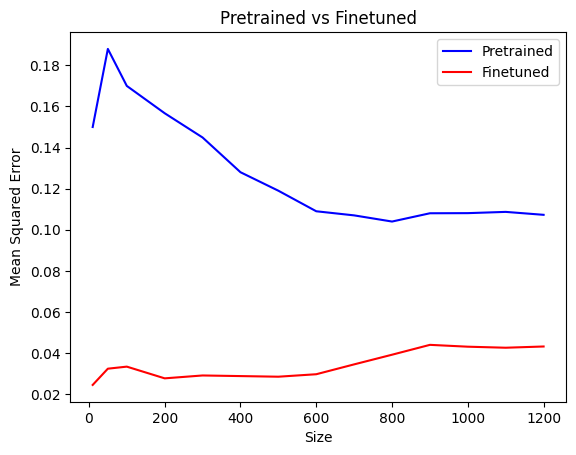

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel("results.xlsx")

# Assuming you have a DataFrame named df with columns 'size', 'Pretrained', and 'Finetuned'

# Create a figure and axes
fig, ax = plt.subplots()

# Plot 'Pretrained' values
ax.plot(df['size'], df['simple_bert'], color='blue', label='Pretrained')

# Plot 'Finetuned' values
ax.plot(df['size'], df['fine_tune_bert'], color='red', label='Finetuned')

# Set labels and title
ax.set_xlabel('Size')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Pretrained vs Finetuned')

# Show the legend
ax.legend()

# Show the plot
plt.show()